### Ejercicio 1

In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import cv2

import os
print(os.listdir("images"))

['nemo0.jpg', 'nemo1.jpg', 'nemo2.jpg', 'nemo3.jpg', 'nemo4.jpg', 'nemo5.jpg']


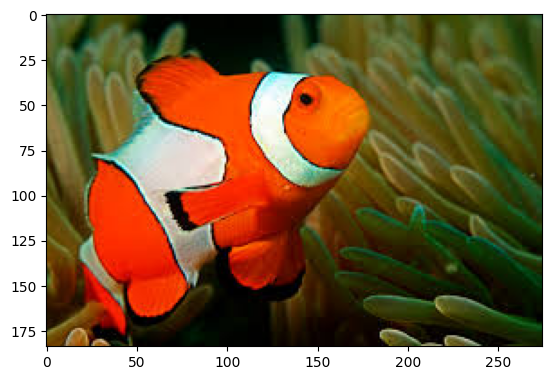

In [137]:
nemo = cv2.imread('./images/nemo0.jpg')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)
plt.show()

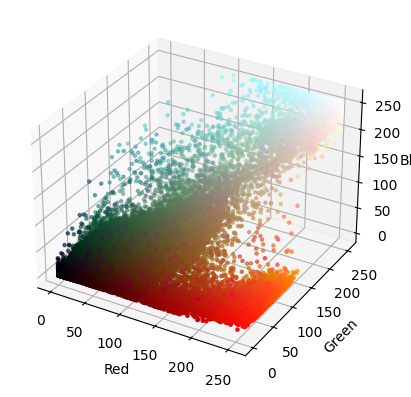

In [138]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm

# Se separan los 3 canales
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# Se normalizan los colores para que cada pixel tenga un color acorde a RGB
pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

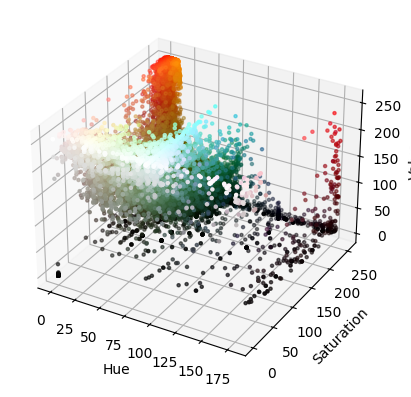

In [139]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)

# Ahora visualizo HSV
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# Los colores se mantienen en RGB porque así lo pide matplotlib
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()


El espacio HSV se asemeja mucho más que el RGB a la forma en que los humanos tenemos de intepretar los colores. Para pasar de un tono de naranja a otro en el espacio RGB puede resultar incierto qué cantidad de los 3 canales modificar, mientras que en HSV se vuelve más intuitivo modificar la matiz (H) la saturación (S) y el valor/brillo (V).

En definitiva, en el espacio HSV los colores son visualmente más separables, quedando localizados por zonas en lugar de estar dispersos por todo el espacio de color, lo cual es un aspecto clave para la segmentación.

Ahora resulta más sencillo elegir un rango de naranjas en HSV para construir una máscara y aplicarla sobre la imagen:

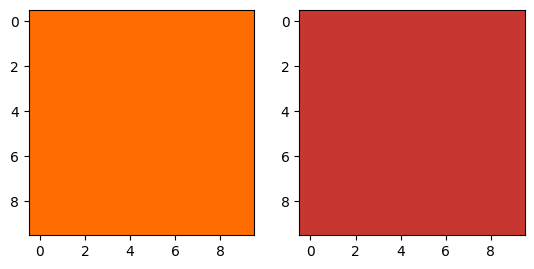

In [140]:
from matplotlib.colors import hsv_to_rgb

light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

lo_square = np.full((10, 10, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_orange, dtype=np.uint8) / 255.0

# Visualizo el rango de colores
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

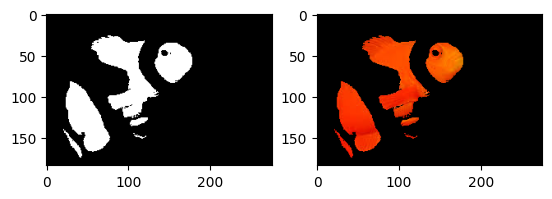

In [141]:
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
result = cv2.bitwise_and(nemo, nemo, mask=mask)

# Veo la máscara
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
# Veo el resultado
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Ya quedaron segmentados los naranjas, faltan los blancos:

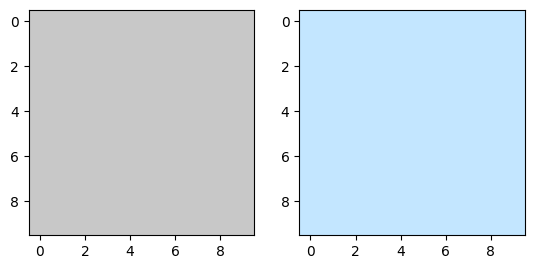

In [142]:
light_white = (0, 0, 200)
dark_white = (145, 60, 255)

lw_square = np.full((10, 10, 3), light_white, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), dark_white, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dw_square))
plt.show()

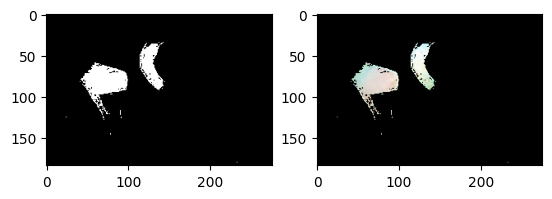

In [143]:
mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

Ahora combinamos las máscaras para tener la imagen final:

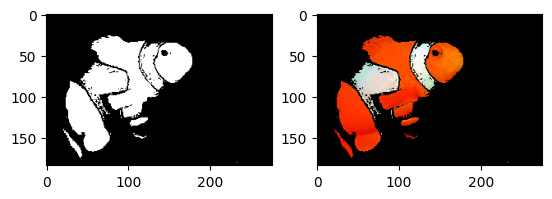

In [144]:
final_mask = mask + mask_white

final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

Una vez hecha la segmentación, es posible aplicar un filtro de desenfoque gaussiano para suavizar los bordes:

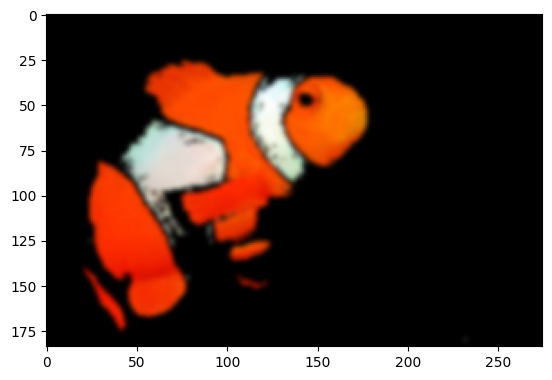

In [145]:
blur = cv2.GaussianBlur(final_result, (7, 7), 0)
plt.imshow(blur)
plt.show()

Mirando todas las fotos de los parientes de Nemo, es posible ver que la segmentación óptima depende de cada imagen en particular, y no del objeto que figura en la imagen en sí. Algunos peces que tienen otros tonos de naranja, o componentes azuladas en sus rayas blancas, escapan de la segmentación encontrada.

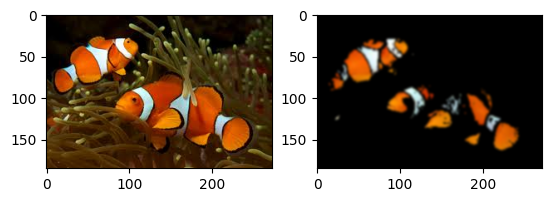

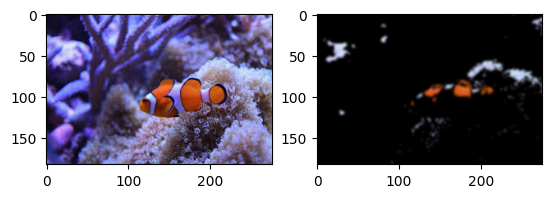

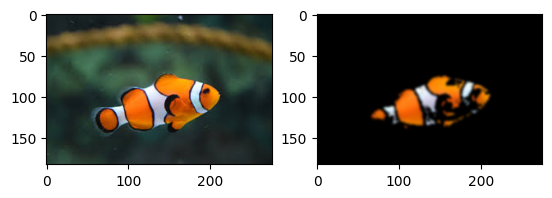

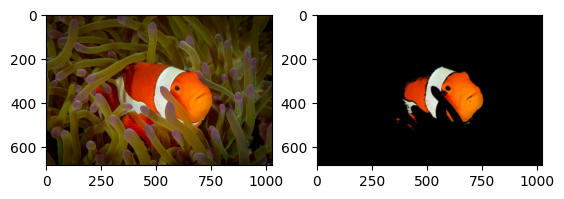

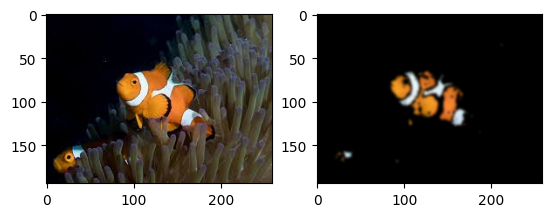

In [147]:
path = "./images/nemo"

nemos_friends = []
for i in range(6):
   friend = cv2.cvtColor(cv2.imread(path + str(i) + ".jpg"), cv2.COLOR_BGR2RGB)
   nemos_friends.append(friend)

def segment_fish(image):
    ''' Attempts to segment the clownfish out of the provided image '''

    # Convert the image into HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Set the orange range
    light_orange = (1, 190, 200)
    dark_orange = (18, 255, 255)

    # Apply the orange mask 
    mask = cv2.inRange(hsv_image, light_orange, dark_orange)

    # Set a white range
    light_white = (0, 0, 200)
    dark_white = (145, 60, 255)

    # Apply the white mask
    mask_white = cv2.inRange(hsv_image, light_white, dark_white)

    # Combine the two masks
    final_mask = mask + mask_white
    result = cv2.bitwise_and(image, image, mask=final_mask)

    # Clean up the segmentation using a blur
    blur = cv2.GaussianBlur(result, (7, 7), 0)
    return blur

results = [segment_fish(friend) for friend in nemos_friends]

for i in range(1, 6):
    plt.subplot(1, 2, 1)
    plt.imshow(nemos_friends[i])
    plt.subplot(1, 2, 2)
    plt.imshow(results[i])
    plt.show()

### Ejercicio 2

Procediendo de manera análoga con la imagen bird.jpg:

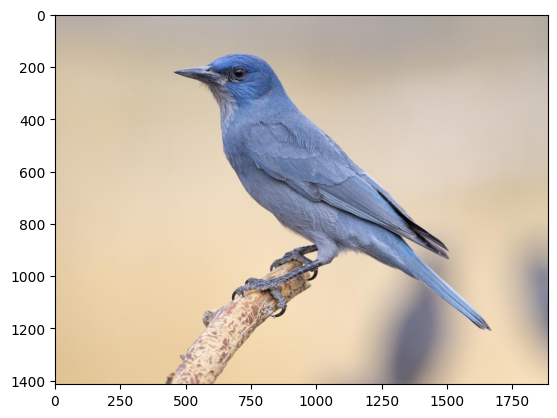

In [150]:
bird = cv2.imread('./bird.jpg')
bird = cv2.cvtColor(bird, cv2.COLOR_BGR2RGB)
plt.imshow(bird)
plt.show()

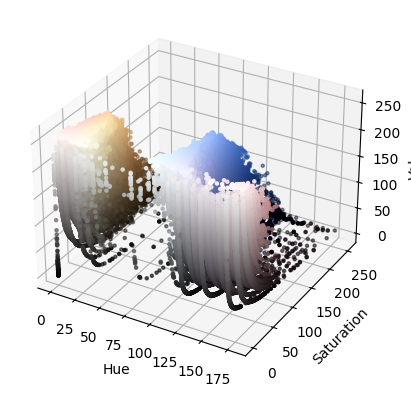

In [152]:
hsv_bird = cv2.cvtColor(bird, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_bird)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = bird.reshape((np.shape(bird)[0]*np.shape(bird)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()


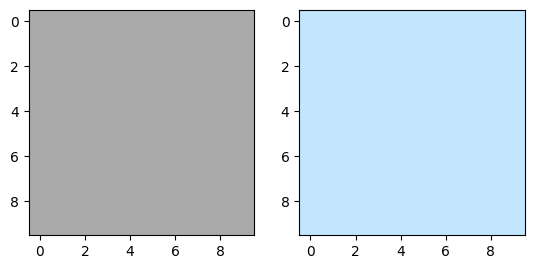

In [215]:
light_white = (40, 0, 170)
dark_white = (145, 60, 255)

lw_square = np.full((10, 10, 3), light_white, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), dark_white, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dw_square))
plt.show()

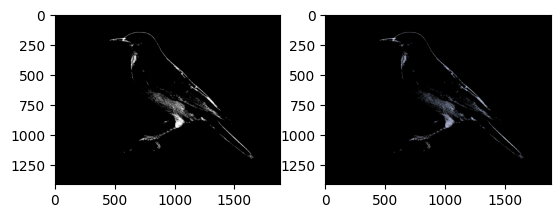

In [216]:
mask_white = cv2.inRange(hsv_bird, light_white, dark_white)
result_white = cv2.bitwise_and(bird, bird, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

Esta máscara segmenta bien el contorno y las patas del pájaro.

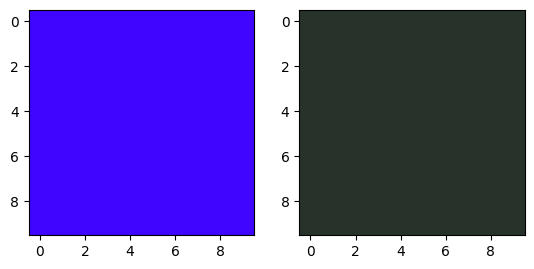

In [217]:
light_blue = (100, 60, 50)
dark_blue = (180, 250, 255)

lo_square = np.full((10, 10, 3), light_blue, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8) / 255.0

# Visualizo el rango de colores
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

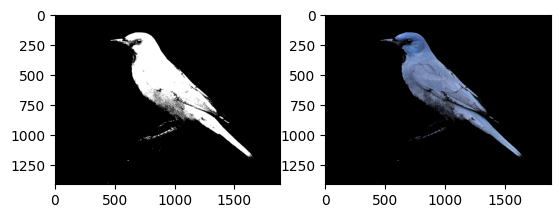

In [218]:
mask = cv2.inRange(hsv_bird, light_blue, dark_blue)
result = cv2.bitwise_and(bird, bird, mask=mask)

# Veo la máscara
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
# Veo el resultado
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Mientras que esta lo hace con el interior del pájaro.

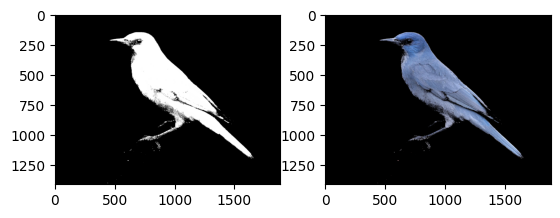

In [219]:
final_mask = mask + mask_white

final_result = cv2.bitwise_and(bird, bird, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

Finalmente la imagen compuesta por ambas máscaras define correctamente todo el pájaro.

### Ejercicio 3

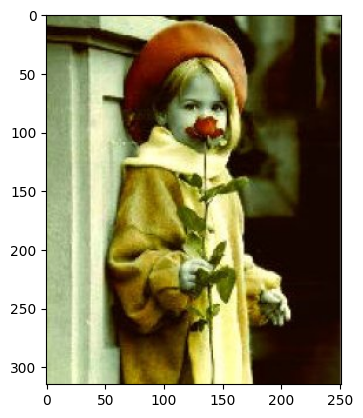

In [400]:
rose = cv2.imread('./rose.jpg')
rose = cv2.cvtColor(rose, cv2.COLOR_BGR2RGB)
plt.imshow(rose)
plt.show()

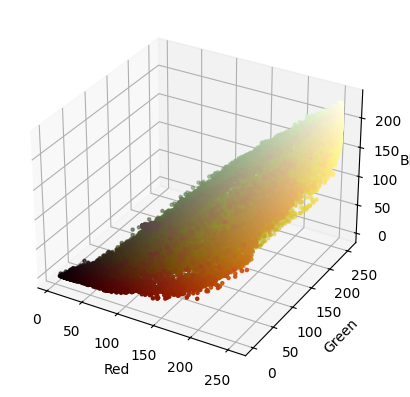

In [401]:
r, g, b = cv2.split(rose)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = rose.reshape((np.shape(rose)[0]*np.shape(rose)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

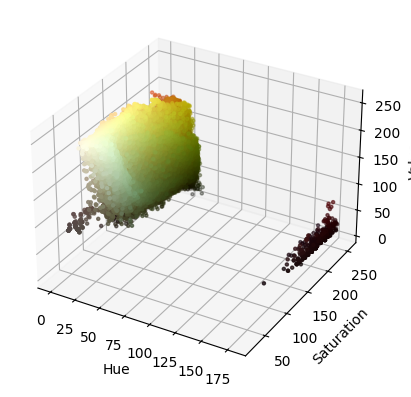

In [402]:
hsv_rose = cv2.cvtColor(rose, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_rose)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()


Se observa lo práctico que resulta este espacio de color para segmentar la rosa. Comparando con RGB:

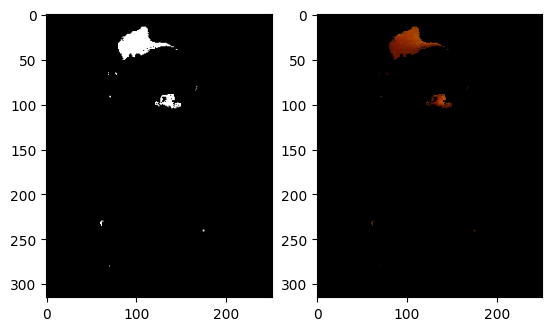

In [403]:
light_red = (5, 215, 70)
dark_red = (13, 255, 250)

mask = cv2.inRange(hsv_rose, light_red, dark_red)
result = cv2.bitwise_and(rose, rose, mask=mask)

# Veo la máscara
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
# Veo el resultado
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

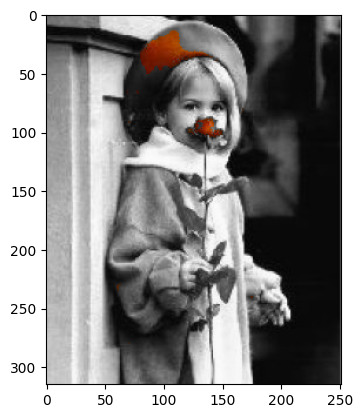

In [404]:
# Convierto a escala de grises
gray = cv2.cvtColor(rose, cv2.COLOR_RGB2GRAY)
gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

# Combino, donde hay rojo pongo la rosa (y el sombrero), donde no hay pongo gris 
isolated = np.where(mask[:, :, None].astype(bool), result, gray_rgb)

plt.imshow(isolated)
plt.show()

### Ejercicio 4

El algoritmo _k-means clustering_ resulta una excelente opción para segmentar el color en una imagen, ya que permite agrupar los colores por cercanía en el espacio de color.

_K-means_ es un algoritmo de agrupamiento no supervisado, es decir que agrupa datos según cierta similitud en sus características (en este caso RGB ó HSV) en _k_ grupos. En una interpretación geométrica, para un conjunto de datos dispersos (a) se eligen _k_ puntos llamados "centroides iniciales" (b), quedando asignado cada punto a su centroide más cercano (c). Luego, los centroides se recalculan a partir de la distancia media del conjunto actual de puntos (d) y se reasignan todos los puntos a su centroide más cercano (e). Los centroides continúan recalculándose y los puntos siguen reasignándose hasta que se alcanza la convergencia o se finaliza el algoritmo (f).

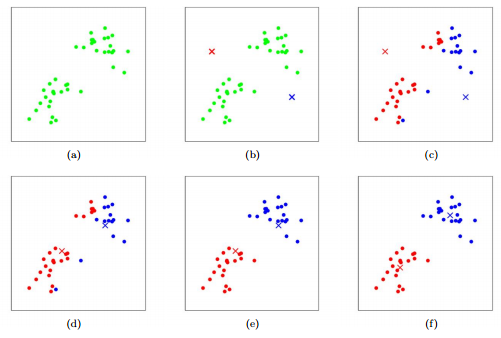

En este caso, se vuelve práctico aplicar _k-means_ en el espacio de color HSV, donde vimos que los colores se agrupan según su similitud (al ojo humano), de modo que los centroides se calcularán promediando los valores de cada uno de los canales H, S y V. Sin embargo, OpenCV tiene incorporada una función _cv2kmeans_ que lo hace muy bien también en RGB. El valor elegido de _k_ entonces será la cantidad de colores que compongan a la imagen final, de modo que se puede representar a la imagen original con una cantidad _k_ de colores a elección, que resulten representativos de los colores que se encuentran más presentes en la imagen (o de sus valores medios).

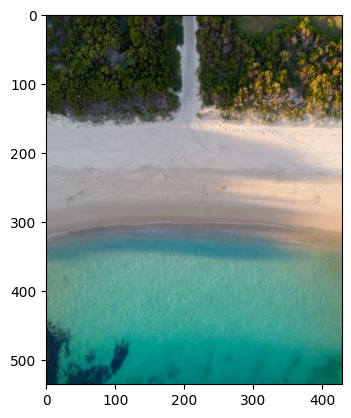

In [410]:
image = cv2.imread('beach.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

plt.imshow(image)


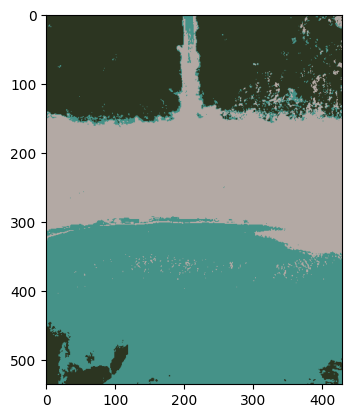

In [ ]:
# Necesito tener una lista de píxeles con sus componentes RGB
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

# Se definen los criterios de parada del algoritmo (100 iteraciones ó 85% de precisión)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# Cantidad de clústers (colores) a detectar
k = 3

# Devuelve la etiqueta de cada píxel y los centroides (RGB)
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
# Mapeo de los píxeles a los centroides (el RGB de cada uno)
segmented_data = centers[labels.flatten()]

# Vuelta al tamaño de la imagen original
segmented_image = segmented_data.reshape((image.shape))

plt.imshow(segmented_image)


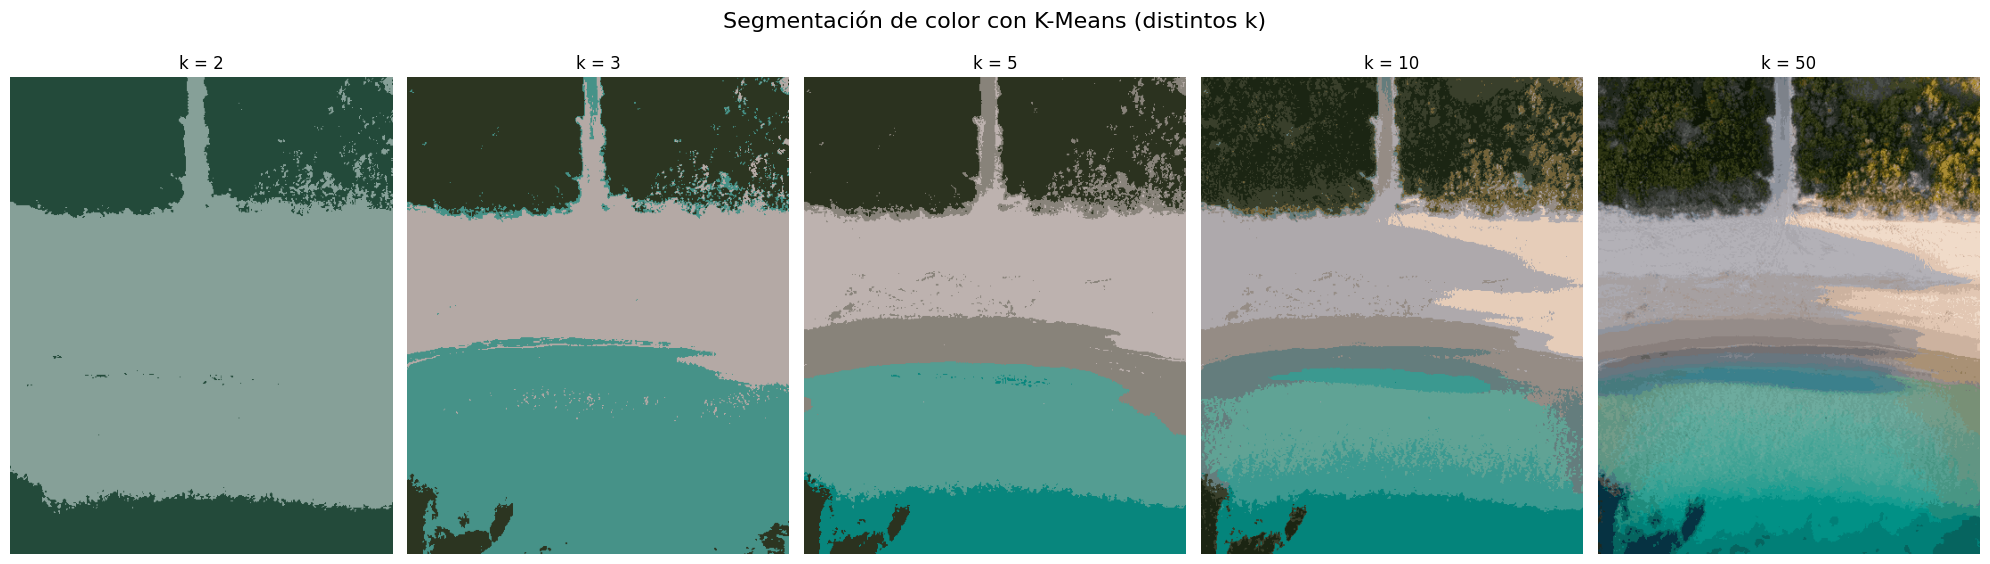

In [431]:
k_values = [2, 3, 5, 10, 50]

fig, axes = plt.subplots(1, len(k_values), figsize=(20, 6))
fig.suptitle("Segmentación de color con K-Means (distintos k)", fontsize=16)

for i, k in enumerate(k_values):
    retval, labels, centers = cv2.kmeans(
        pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape(image.shape)

    axes[i].imshow(segmented_image)
    axes[i].set_title(f'k = {k}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Se observa que con _k=50_, a simple vista la imagen no presenta diferencias significativas con la imagen original.